In [1]:
pip install keras tensorflow scikit-learn numpy


Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd

# Load ARP MITM data and labels
arp_mitm_data = pd.read_csv('ARP_MitM_dataset.csv')
arp_mitm_labels = pd.read_csv('ARP_MitM_labels.csv')


In [14]:
# Use the union of features for training and evaluation
selected_features = [64, 9, 74, 12, 77, 78, 79, 14, 24, 27, 108, 51, 58, 62, 63]
arp_mitm_data = arp_mitm_data.iloc[:, selected_features]




In [15]:
# Check the columns in arp_mitm_labels
print(arp_mitm_labels.columns)

# Assuming the column containing the labels is named 'Label' (you can adjust this if it's different)
arp_mitm_data['Label'] = arp_mitm_labels['x']

# Continue with the rest of the code
benign_filter = arp_mitm_data['Label'] == 'Benign'
X = arp_mitm_data.drop(columns=['Label'])
X_train, X_test, y_train, y_test = train_test_split(X, arp_mitm_data['Label'], test_size=0.2, shuffle=True)


Index(['Unnamed: 0', 'x'], dtype='object')


In [16]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

def create_autoencoder(input_dim):
    # Define the size of the encoded representations
    encoding_dim = int(input_dim / 2)  # Feel free to adjust this value as needed

    # Define input layer
    input_layer = Input(shape=(input_dim,))

    # Define encoding layers
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    # You can add more layers here if needed

    # Define decoding layers
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    # You can add more layers here if needed

    # Combine the layers to create the autoencoder model
    autoencoder = Model(input_layer, decoded)

    return autoencoder


In [17]:
print(X_train_benign.shape)
print(y_train.head())


(1087672, 15)
2014889    1
406304     0
20279      0
149238     0
474226     0
Name: Label, dtype: int64


In [18]:
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

# 1. Feature Scaling:
# Assuming X_train and X_test are already split before this step.
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 2. Use Only Benign Data for Training:
X_train_benign = X_train[y_train == 0]  # Assuming 0 denotes 'Benign'

# 3. Model Creation and Compilation:
input_dim = X_train_benign.shape[1]
autoencoder = create_autoencoder(input_dim)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')  # Use `learning_rate` instead of `lr`

# 4. Early Stopping:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 5. Training the Model:
autoencoder.fit(X_train_benign, X_train_benign,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping])



Epoch 1/50
  23/4246 [..............................] - ETA: 20s - loss: 1.3914

2023-10-30 11:28:05.942294: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


4246/4246 [==============================] - 23s 5ms/step - loss: 0.8678 - val_loss: 0.7283
Epoch 2/50
4246/4246 [==============================] - 22s 5ms/step - loss: 0.8254 - val_loss: 0.7248
Epoch 3/50
4246/4246 [==============================] - 22s 5ms/step - loss: 0.8245 - val_loss: 0.7222
Epoch 4/50
4246/4246 [==============================] - 22s 5ms/step - loss: 0.8242 - val_loss: 0.7214
Epoch 5/50
4246/4246 [==============================] - 22s 5ms/step - loss: 0.8242 - val_loss: 0.7209
Epoch 6/50
4246/4246 [==============================] - 22s 5ms/step - loss: 0.8242 - val_loss: 0.7210
Epoch 7/50
4246/4246 [==============================] - 22s 5ms/step - loss: 0.8242 - val_loss: 0.7208
Epoch 8/50
4246/4246 [==============================] - 22s 5ms/step - loss: 0.8242 - val_loss: 0.7210
Epoch 9/50
4246/4246 [==============================] - 22s 5ms/step - loss: 0.8243 - val_loss: 0.7211
Epoch 10/50
4246/4246 [==============================] - 22s 5ms/step - loss: 0.8243

In [19]:
import numpy as np

# Predict the test set
predictions = autoencoder.predict(X_test)

# Calculate mean squared error between predictions and actual values
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

# Convert labels for easier analysis: Benign = 0, Attack = 1
y_test_binary = (y_test != 'Benign').astype(int)




15652/15652 [==============================] - 17s 1ms/step


15652/15652 [==============================] - 18s 1ms/step


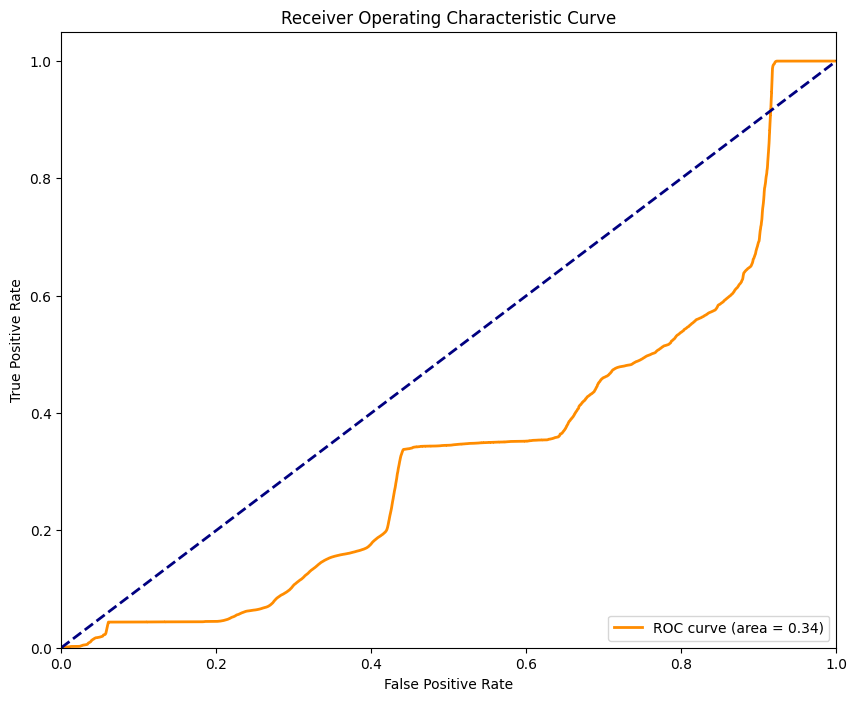

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Using the autoencoder to make predictions on the test set
X_test_predictions = autoencoder.predict(X_test)

# Calculating the mean squared error between the original data and their reconstructions
mse = np.mean(np.power(X_test - X_test_predictions, 2), axis=1)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


In [21]:
from sklearn.metrics import f1_score, accuracy_score

# Using the autoencoder to make predictions on the test set
X_test_predictions = autoencoder.predict(X_test)

# Calculating the mean squared error between the original data and their reconstructions
mse = np.mean(np.power(X_test - X_test_predictions, 2), axis=1)

# Choose a threshold value for which F1 score is maximized (you can also use other methods to determine this threshold)
thresholds = np.linspace(0.1, 10, 200)  # Adjust the range and granularity as needed
f1_scores = [f1_score(y_test, mse > threshold) for threshold in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Predicting anomalies using the optimal threshold
y_pred = (mse > optimal_threshold).astype(int)

# Calculating F1 score and accuracy
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")


15652/15652 [==============================] - 18s 1ms/step
Optimal Threshold: 0.5477386934673367
F1 Score: 0.3629392556008643
Accuracy: 0.4519540624613161
